In [2]:
library('RODBC')
library('quantmod')
library('PerformanceAnalytics')
source("/usr/common/config.R")
lcon <- odbcDriverConnect(sprintf("Driver={SQL Server};Server=%s;Database=%s;Uid=%s;Pwd=%s;", ldbserver, ldbname, ldbuser, ldbpassword), case = "nochange", believeNRows = TRUE)

In [15]:
maxMetaDate<-as.Date(sqlQuery(lcon, "select max(time_stamp) from etf_meta")[[1]])
maxPxDate<-as.Date(sqlQuery(lcon, "select max(time_stamp) from BHAV_EQ_TIINGO")[[1]])

etfs<-sqlQuery(lcon, sprintf("SELECT SYMBOL,FUND FROM ETF_META 
                                WHERE ((GEO='INDIA'
                                AND ASSET_CLASS='EQUITY'
                                AND FUND_CLOSURE_RISK='LOW') or (SYMBOL='SPY'))
                                AND TIME_STAMP='%s'
                                ORDER BY AUM DESC", maxMetaDate))

print(etfs)

   SYMBOL                                     FUND
1     SPY                   SPDR S&P 500 ETF Trust
2    INDA                   iShares MSCI India ETF
3     EPI           WisdomTree India Earnings Fund
4    INDY                     iShares India 50 ETF
5    SCIF VanEck Vectors India Small-Cap Index ETF
6     PIN              PowerShares India Portfolio
7     INP               iPath MSCI India Index ETN
8    SMIN         iShares MSCI India Small Cap ETF
9    INCO              Columbia India Consumer ETF
10   INDL Direxion Daily MSCI India Bull 3x Shares
11   INXX        Columbia India Infrastructure ETF


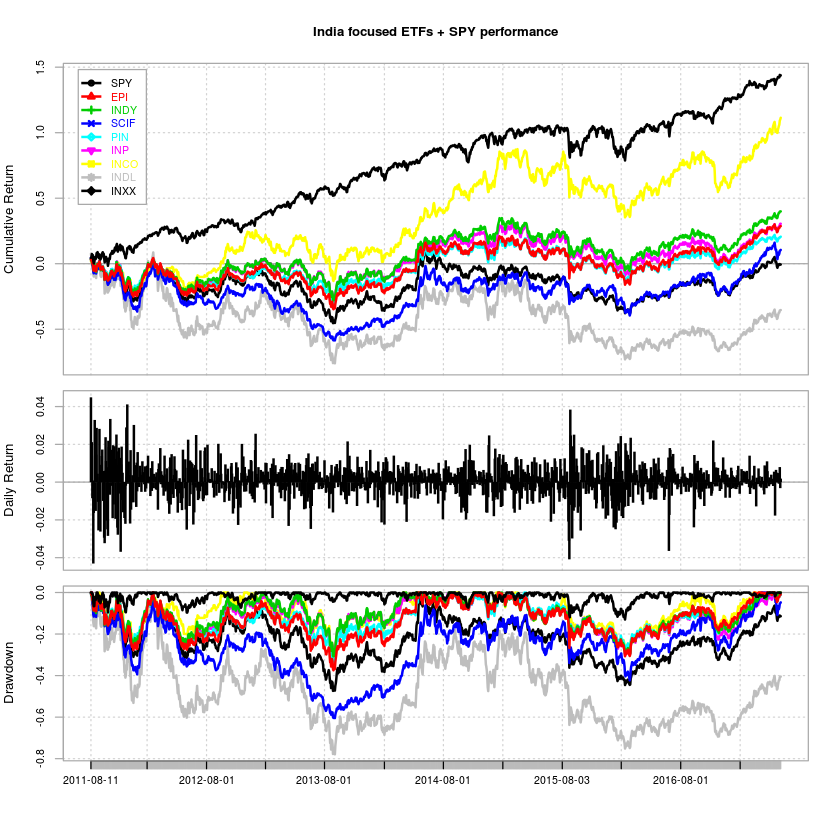

In [16]:
retXts<-xts()
selectedEtfs<-c()
for(i in 1:length(etfs[,1])){
    sym<-toString(etfs[i,1])
    pxSeries<-sqlQuery(lcon, sprintf("select time_stamp, px_close_adj from BHAV_EQ_TIINGO
                                        WHERE symbol='%s' order by time_stamp desc", sym))
    
    if(as.Date(pxSeries[1,1]) != maxPxDate){ 
        next
    }
    
    selectedEtfs<-c(selectedEtfs, sym)
    pXts<-xts(pxSeries[,2], as.Date(pxSeries[,1]))
    retXts<-merge(retXts, dailyReturn(pXts))
}
    
retXts<-na.omit(retXts)
retXts<-retXts[-1,]
names(retXts)<-selectedEtfs
charts.PerformanceSummary(retXts, main="India focused ETFs + SPY performance")

In [17]:
retDf<-data.frame(SYMBOL="", CUM_RET=0.0, ANN_RET=0.0, stringsAsFactors = F)
for(i in 1:length(selectedEtfs)){
    retDf<-rbind(retDf, c(selectedEtfs[i], Return.cumulative(retXts["2012/",selectedEtfs[i]]), Return.annualized(retXts["2012/",selectedEtfs[i]])))
}

retDf<-retDf[-1,]
retDf[,2]<-round(as.numeric(retDf[,2])*100,2)
retDf[,3]<-round(as.numeric(retDf[,3])*100,2)

print("since 2012")
print(retDf)

[1] "since 2012"
   SYMBOL CUM_RET ANN_RET
2     SPY  115.63   15.25
3     EPI   70.47   10.36
4    INDY   78.93   11.35
5    SCIF   74.11   10.79
6     PIN   50.53    7.85
7     INP   68.36   10.10
8    INCO  164.49   19.69
9    INDL   20.98    3.58
10   INXX   38.16    6.15
